# IMPORTANDO BIBLIOTECAS

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit



# CONHECENDO O DATAFRAME

### IMPORTANDO A BASE E VISUALIZANDO
    dados de 2006 a 2025

In [96]:
#armazenando os dados em df
df = pd.read_csv("Dados Históricos - Ibovespa 2107.csv")

In [97]:
# Data     | Data da ocorrência.
# Último   | Valor de fechamento do índice naquele dia.
# Abertura | Valor do índice no início do pregão (quando o mercado abriu).
# Máxima   | Maior valor atingido pelo índice durante o dia. 
# Mínima   | Menor valor atingido pelo índice durante o dia. 
# Volume   | Quantidade de dinheiro movimentado nas negociações do dia.
# Var%     | Variação percentual em relação ao dia anterior.

In [98]:
#visualizando as primeiras linhas do DataFrame
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,21.07.2025,134.167,133.382,134.865,133.367,"6,73B","0,59%"
1,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
2,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"
3,16.07.2025,135.511,135.250,135.641,134.265,"7,83B","0,19%"
4,15.07.2025,135.250,135.298,136.022,134.380,"6,90B","-0,04%"


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4826 entries, 0 to 4825
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4826 non-null   object 
 1   Último    4826 non-null   float64
 2   Abertura  4826 non-null   float64
 3   Máxima    4826 non-null   float64
 4   Mínima    4826 non-null   float64
 5   Vol.      4825 non-null   object 
 6   Var%      4826 non-null   object 
dtypes: float64(4), object(3)
memory usage: 264.1+ KB


In [100]:
df.shape

(4826, 7)

In [101]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [102]:
df[df['Vol.'].isnull()]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
2345,10.02.2016,40.377,40.592,40.592,39.96,NaN,"-0,53%"


In [103]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,4826.000000,4826.000000,4826.000000,4826.000000
mean,76.262266,76.242557,76.963464,75.529829
std,29.063098,29.056846,29.195943,28.925589
min,29.435000,29.438000,31.480000,29.435000
25%,53.699000,53.691000,54.193500,53.039500
50%,65.093000,65.082000,65.701000,64.494500
75%,103.778000,103.776500,104.617250,102.794500
max,141.264000,141.265000,141.564000,140.597000


### LIMPANDO E FORMATANDO A BASE

In [104]:
# #excluindo a linha em branco de volume 

# df.dropna(subset=['Vol.'], inplace=True)

# df.isnull().sum()

In [105]:
#renomeando as colunas do DataFrame
df.columns = ['data', 'ultimo', 'abertura', 'maximo', 'minimo', 'volume', 'variacao']


In [106]:
#alterando o tipo da coluna 'data' para datetime
df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')

#normalizando hora para 00:00:00
df['data'] = df['data'].dt.normalize()



In [107]:
#definindo a coluna 'data' como índice
df.set_index('data', inplace=True)

#ordenando o DataFrame pelo índice (data) em ordem crescente
df.sort_index(inplace=True)

In [108]:
df.head()

,ultimo,abertura,maximo,minimo,volume,variacao
data,,,,,,
2006-01-23,36.632,36.687,36.771,36.213,"104,57M","-0,17%"
2006-01-24,37.400,36.632,37.428,36.632,"108,83M","2,10%"
2006-01-26,38.014,37.402,38.031,37.402,"168,27M","1,64%"
2006-01-27,37.822,38.018,38.804,37.688,"146,82M","-0,51%"
2006-01-30,38.242,37.824,38.276,37.501,"103,24M","1,11%"


In [109]:
###### FILTRANDO PERIODO DE N ANOS ######

data_final_dataset = df.index.max() # Pega a data mais recente do dataset
data_inicio_filtro = data_final_dataset - pd.DateOffset(years=6) # Calcula a data de N anos atrás

# Aplica o filtro no DataFrame
df = df[df.index >= data_inicio_filtro]


In [110]:
df.head()

,ultimo,abertura,maximo,minimo,volume,variacao
data,,,,,,
2019-07-22,103.949,103.452,104.278,103.452,"3,57M","0,48%"
2019-07-23,103.704,103.949,104.430,103.518,"4,18M","-0,24%"
2019-07-24,104.120,103.707,104.570,103.707,"5,02M","0,40%"
2019-07-25,102.655,104.119,104.440,102.390,"5,98M","-1,41%"
2019-07-26,102.819,102.654,103.209,102.196,"5,30M","0,16%"


In [111]:
df.shape

(1494, 6)

In [112]:
# --- FUNÇÃO PARA TRATAR O VOLUME ---
def converter_volume(volume_str):
    """
    Converte strings de volume (ex: '40,6B', '32,45M', '453K') para números float.
    Lida com vírgulas como separadores decimais e abreviações B, M, K.
    Retorna 0.0 se a string for '-'. Imprime um aviso para formatos desconhecidos.
    """
    if pd.isna(volume_str) or volume_str is None: # Trata valores NaN ou None
        return 0.0

    if isinstance(volume_str, (int, float)): # Se já for numérico, retorna como está
        return float(volume_str)

    volume_str = str(volume_str).strip() # Garante que é string e remove espaços
    if volume_str == '-':
        return 0.0

    volume_str = volume_str.replace(',', '.') #substitui vírgula por ponto para conversão correta

    try:
        if 'B' in volume_str:
            return float(volume_str.replace('B', '')) * 1_000_000_000
        elif 'M' in volume_str:
            return float(volume_str.replace('M', '')) * 1_000_000
        elif 'K' in volume_str:
            return float(volume_str.replace('K', '')) * 1_000
        else:
            return float(volume_str)
    except ValueError:
        print(f"Aviso: Não foi possível converter o volume '{volume_str}'. Retornando 0.0.")
        return 0.0

In [113]:
# --- FUNÇÃO PARA TRATAR A VARIAÇÃO PERCENTUAL ---
def converter_variacao_percentual(variacao_str):
    """
    Converte strings de variação percentual ('+0,50%', '-1,23%') para números float.
    Remove o '%' e substitui vírgula por ponto.
    Retorna 0.0 para strings como '-'.
    """
    if pd.isna(variacao_str) or variacao_str is None:
        return 0.0

    if isinstance(variacao_str, (int, float)):
        return float(variacao_str)

    variacao_str = str(variacao_str).strip()
    if variacao_str == '-':
        return 0.0

    variacao_str = variacao_str.replace('%', '').replace(',', '.')
    
    try:
        return float(variacao_str)
    except ValueError:
        print(f"Aviso: Não foi possível converter a variação percentual '{variacao_str}'. Retornando 0.0.")
        return 0.0

In [114]:
#aplicando as funções de ajuste nas colunas 'volume' e 'variacao'
df['volume'] = df['volume'].apply(converter_volume).round(2)
df['variacao'] = df['variacao'].apply(converter_variacao_percentual) / 100  #divide por 100 para manter valor como proporção

In [115]:
df.head(30)

,ultimo,abertura,maximo,minimo,volume,variacao
data,,,,,,
2019-07-22,103.949,103.452,104.278,103.452,3570000.0,0.0048
2019-07-23,103.704,103.949,104.430,103.518,4180000.0,-0.0024
2019-07-24,104.120,103.707,104.570,103.707,5020000.0,0.0040
2019-07-25,102.655,104.119,104.440,102.390,5980000.0,-0.0141
2019-07-26,102.819,102.654,103.209,102.196,5300000.0,0.0016
2019-07-29,103.483,102.817,103.483,102.461,3670000.0,0.0065
2019-07-30,102.933,103.483,103.555,102.596,4190000.0,-0.0053
2019-07-31,101.812,102.946,103.129,100.950,5230000.0,-0.0109
2019-08-01,102.126,101.819,104.056,101.819,7350000.0,0.0031


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1494 entries, 2019-07-22 to 2025-07-21
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ultimo    1494 non-null   float64
 1   abertura  1494 non-null   float64
 2   maximo    1494 non-null   float64
 3   minimo    1494 non-null   float64
 4   volume    1494 non-null   float64
 5   variacao  1494 non-null   float64
dtypes: float64(6)
memory usage: 81.7 KB


In [117]:
df.describe()

,ultimo,abertura,maximo,minimo,volume,variacao
count,1494.000000,1494.000000,1494.000000,1494.000000,1.494000e+03,1494.000000
mean,114.538629,114.518516,115.498583,113.555212,9.186519e+08,0.000294
std,13.148925,13.142194,12.914581,13.354405,3.002257e+09,0.015390
min,63.570000,63.604000,67.604000,61.691000,2.690000e+06,-0.147800
25%,105.738000,105.708000,106.769500,104.786750,8.572500e+06,-0.007075
50%,115.094500,115.077500,115.914500,114.009500,1.066000e+07,0.000450
75%,125.261500,125.213500,126.074750,124.414000,1.317750e+07,0.008000
max,141.264000,141.265000,141.564000,140.597000,2.487000e+10,0.139100


### VISUALIZANDO OS DADOS

In [118]:
fig = px.line(
    df, 
    x= df.index, 
    y= df.columns,
    title= 'Tendência do IBOVESPA de 2006 a 2025',
    #color='País', #Para definir uma cor a cada coluna de País
    markers=False)  #para incluir marcador deixar = True)

#criando o grafico (figura)

fig.update_layout(
    width= 1000, #ajuste da largura
    height= 500, #ajuste da altura
    #xaxis={'tickangle' : -45}, #ajuste do eixo x {rotação}
    xaxis_title= 'Ano', #titulo eixo x
    yaxis_title= 'Valor', #titulo eixo y
    font_family= 'Arial', #mudando as fontes 
    font_size= 12, #tamanho das fontes
    font_color='grey', #cores da fonte
    title_font_color= 'black', #cores do titulo
    title_font_size= 16 #tamanho do titulo

    )

fig.show()

<Axes: >

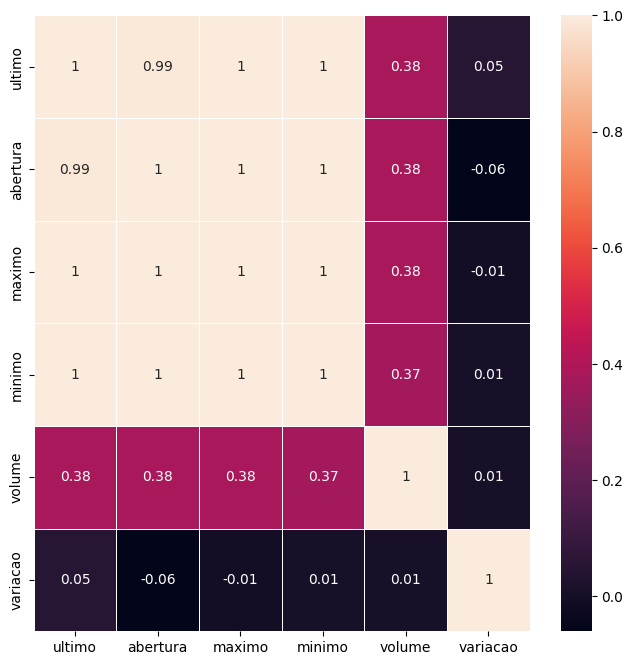

In [119]:
correlation_matrix = df.corr().round(2)

fig, ax = plt.subplots(figsize=(8,8))    
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

# ENGENHARIA DE ATRIBUTOS

## CRIANDO COLUNAS ADICIONAIS PARA A ANÁLISE

##### DIA ATUAL

In [120]:
# amplitude_diaria
df['amplitude_diaria'] = df['maximo'] - df['minimo']

# amplitude_diaria_percentual
df['amplitude_diaria_percentual'] = ((df['amplitude_diaria'] / df['ultimo']) * 100).round(2)

##### DIA ANTERIOR

In [121]:
# fechamento_ontem
df['fechamento_ontem'] = df['ultimo'].shift(1)

# abertura_ontem
df['abertura_ontem'] = df['abertura'].shift(1)

# maximo_ontem
df['maximo_ontem'] = df['maximo'].shift(1)

# minimo_ontem
df['minimo_ontem'] = df['minimo'].shift(1)

# volume_ontem
df['volume_ontem'] = df['volume'].shift(1)

# variacao_ontem
df['variacao_ontem'] = df['variacao'].shift(1)

##### 2 DIAS ATRAS

In [122]:
# fechamento_2d_atras
df['fechamento_2d_atras'] = df['ultimo'].shift(2)

# abertura_2d_atras
df['abertura_2d_atras'] = df['abertura'].shift(2)

# maximo_2d_atras
df['maximo_2d_atras'] = df['maximo'].shift(2)

# minimo_2d_atras
df['minimo_2d_atras'] = df['minimo'].shift(2)

# volume_2d_atras
df['volume_2d_atras'] = df['volume'].shift(2)

# variacao_2d_atras
df['variacao_2d_atras'] = df['variacao'].shift(2)

##### 3 DIAS ATRAS

In [123]:
# fechamento_3d_atras
df['fechamento_3d_atras'] = df['ultimo'].shift(3)

# abertura_3d_atras
df['abertura_3d_atras'] = df['abertura'].shift(3)

# maximo_3d_atras
df['maximo_3d_atras'] = df['maximo'].shift(3)

# minimo_3d_atras
df['minimo_3d_atras'] = df['minimo'].shift(3)

# volume_3d_atras
df['volume_3d_atras'] = df['volume'].shift(3)

# variacao_3d_atras
df['variacao_3d_atras'] = df['variacao'].shift(3)

##### PERÍODOS (MÉDIA MOVEL)

In [124]:
#-------FECHAMENTO--------

# mm_fechamento_5d
df['mm_fechamento_5d'] = df['ultimo'].rolling(window=5).mean().shift(1)

# mm_fechamento_10d 
df['mm_fechamento_10d'] = df['ultimo'].rolling(window=10).mean().shift(1)

# mm_fechamento_20d 
df['mm_fechamento_20d'] = df['ultimo'].rolling(window=20).mean().shift(1)


#-------ABERTURA--------

# mm_abertura_5d
df['mm_abertura_5d'] = df['abertura'].rolling(window=5).mean().shift(1)

# mm_abertura_10d 
df['mm_abertura_10d'] = df['abertura'].rolling(window=10).mean().shift(1)

# mm_abertura_20d 
df['mm_abertura_20d'] = df['abertura'].rolling(window=20).mean().shift(1)



#-------MINIMO--------

# mm_abertura_5d
df['mm_minimo_5d'] = df['minimo'].rolling(window=5).mean().shift(1)

# mm_minimo_10d 
df['mm_minimo_10d'] = df['minimo'].rolling(window=10).mean().shift(1)

# mm_minimo_20d 
df['mm_minimo_20d'] = df['minimo'].rolling(window=20).mean().shift(1)



#-------MAXIMO--------

# mm_abertura_5d
df['mm_maximo_5d'] = df['maximo'].rolling(window=5).mean().shift(1)

# mm_maximo_10d 
df['mm_maximo_10d'] = df['maximo'].rolling(window=10).mean().shift(1)

# mm_maximo_20d 
df['mm_maximo_20d'] = df['maximo'].rolling(window=20).mean().shift(1)


#-------VOLUME--------

# mm_volume_5d
df['mm_volume_5d'] = df['volume'].rolling(window=5).mean().shift(1)

# mm_volume_10d 
df['mm_volume_10d'] = df['volume'].rolling(window=10).mean().shift(1)

# mm_volume_20d 
df['mm_volume_20d'] = df['volume'].rolling(window=20).mean().shift(1)



#-------VARIACAO--------

# mm_volume_5d
df['mm_variacao_5d'] = df['variacao'].rolling(window=5).mean().shift(1)

# mm_variacao_10d 
df['mm_variacao_10d'] = df['variacao'].rolling(window=10).mean().shift(1)

# mm_variacao_20d 
df['mm_variacao_20d'] = df['variacao'].rolling(window=20).mean().shift(1)


##### PERÍODOS (VARIAÇÃO)

In [125]:
#-------FECHAMENTO--------

# v_fechamento_5d
df['v_fechamento_5d'] = (df['ultimo'] / df['ultimo'].shift(5) - 1) 

# v_fechamento_10d
df['v_fechamento_10d'] = (df['ultimo'] / df['ultimo'].shift(10) - 1) 

# v_fechamento_20d
df['v_fechamento_20d'] =(df['ultimo'] / df['ultimo'].shift(20) - 1) 


#-------ABERTURA--------

# v_abertura_5d
df['v_abertura_5d'] = (df['abertura'] / df['abertura'].shift(5) - 1) 

# v_abertura_10d
df['v_abertura_10d'] = (df['abertura'] / df['abertura'].shift(10) - 1) 

# v_abertura_20d
df['v_abertura_20d'] =(df['abertura'] / df['abertura'].shift(20) - 1) 


#-------MINIMO--------

# v_minimo_5d
df['v_minimo_5d'] = (df['minimo'] / df['minimo'].shift(5) - 1) 

# v_minimo_10d
df['v_minimo_10d'] = (df['minimo'] / df['minimo'].shift(10) - 1) 

# v_minimo_20d
df['v_minimo_20d'] =(df['minimo'] / df['minimo'].shift(20) - 1) 


#-------MAXIMO--------

# v_maximo_5d
df['v_maximo_5d'] = (df['maximo'] / df['maximo'].shift(5) - 1) 

# v_maximo_10d
df['v_maximo_10d'] = (df['maximo'] / df['maximo'].shift(10) - 1) 

# v_maximo_20d
df['v_maximo_20d'] =(df['maximo'] / df['maximo'].shift(20) - 1) 


#-------VOLUME--------

# v_volume_5d
df['v_volume_5d'] = (df['volume'] / df['volume'].shift(5) - 1) 

# v_volume_10d
df['v_volume_10d'] = (df['volume'] / df['volume'].shift(10) - 1) 

# v_volume_20d
df['v_volume_20d'] =(df['volume'] / df['volume'].shift(20) - 1) 



#-------VARIACAO--------

# v_variacao_5d
df['v_variacao_5d'] = (df['variacao'] / df['variacao'].shift(5) - 1) 

# v_variacao_10d
df['v_variacao_10d'] = (df['variacao'] / df['variacao'].shift(10) - 1) 

# v_variacao_20d
df['v_variacao_20d'] =(df['variacao'] / df['variacao'].shift(20) - 1) 




<Axes: >

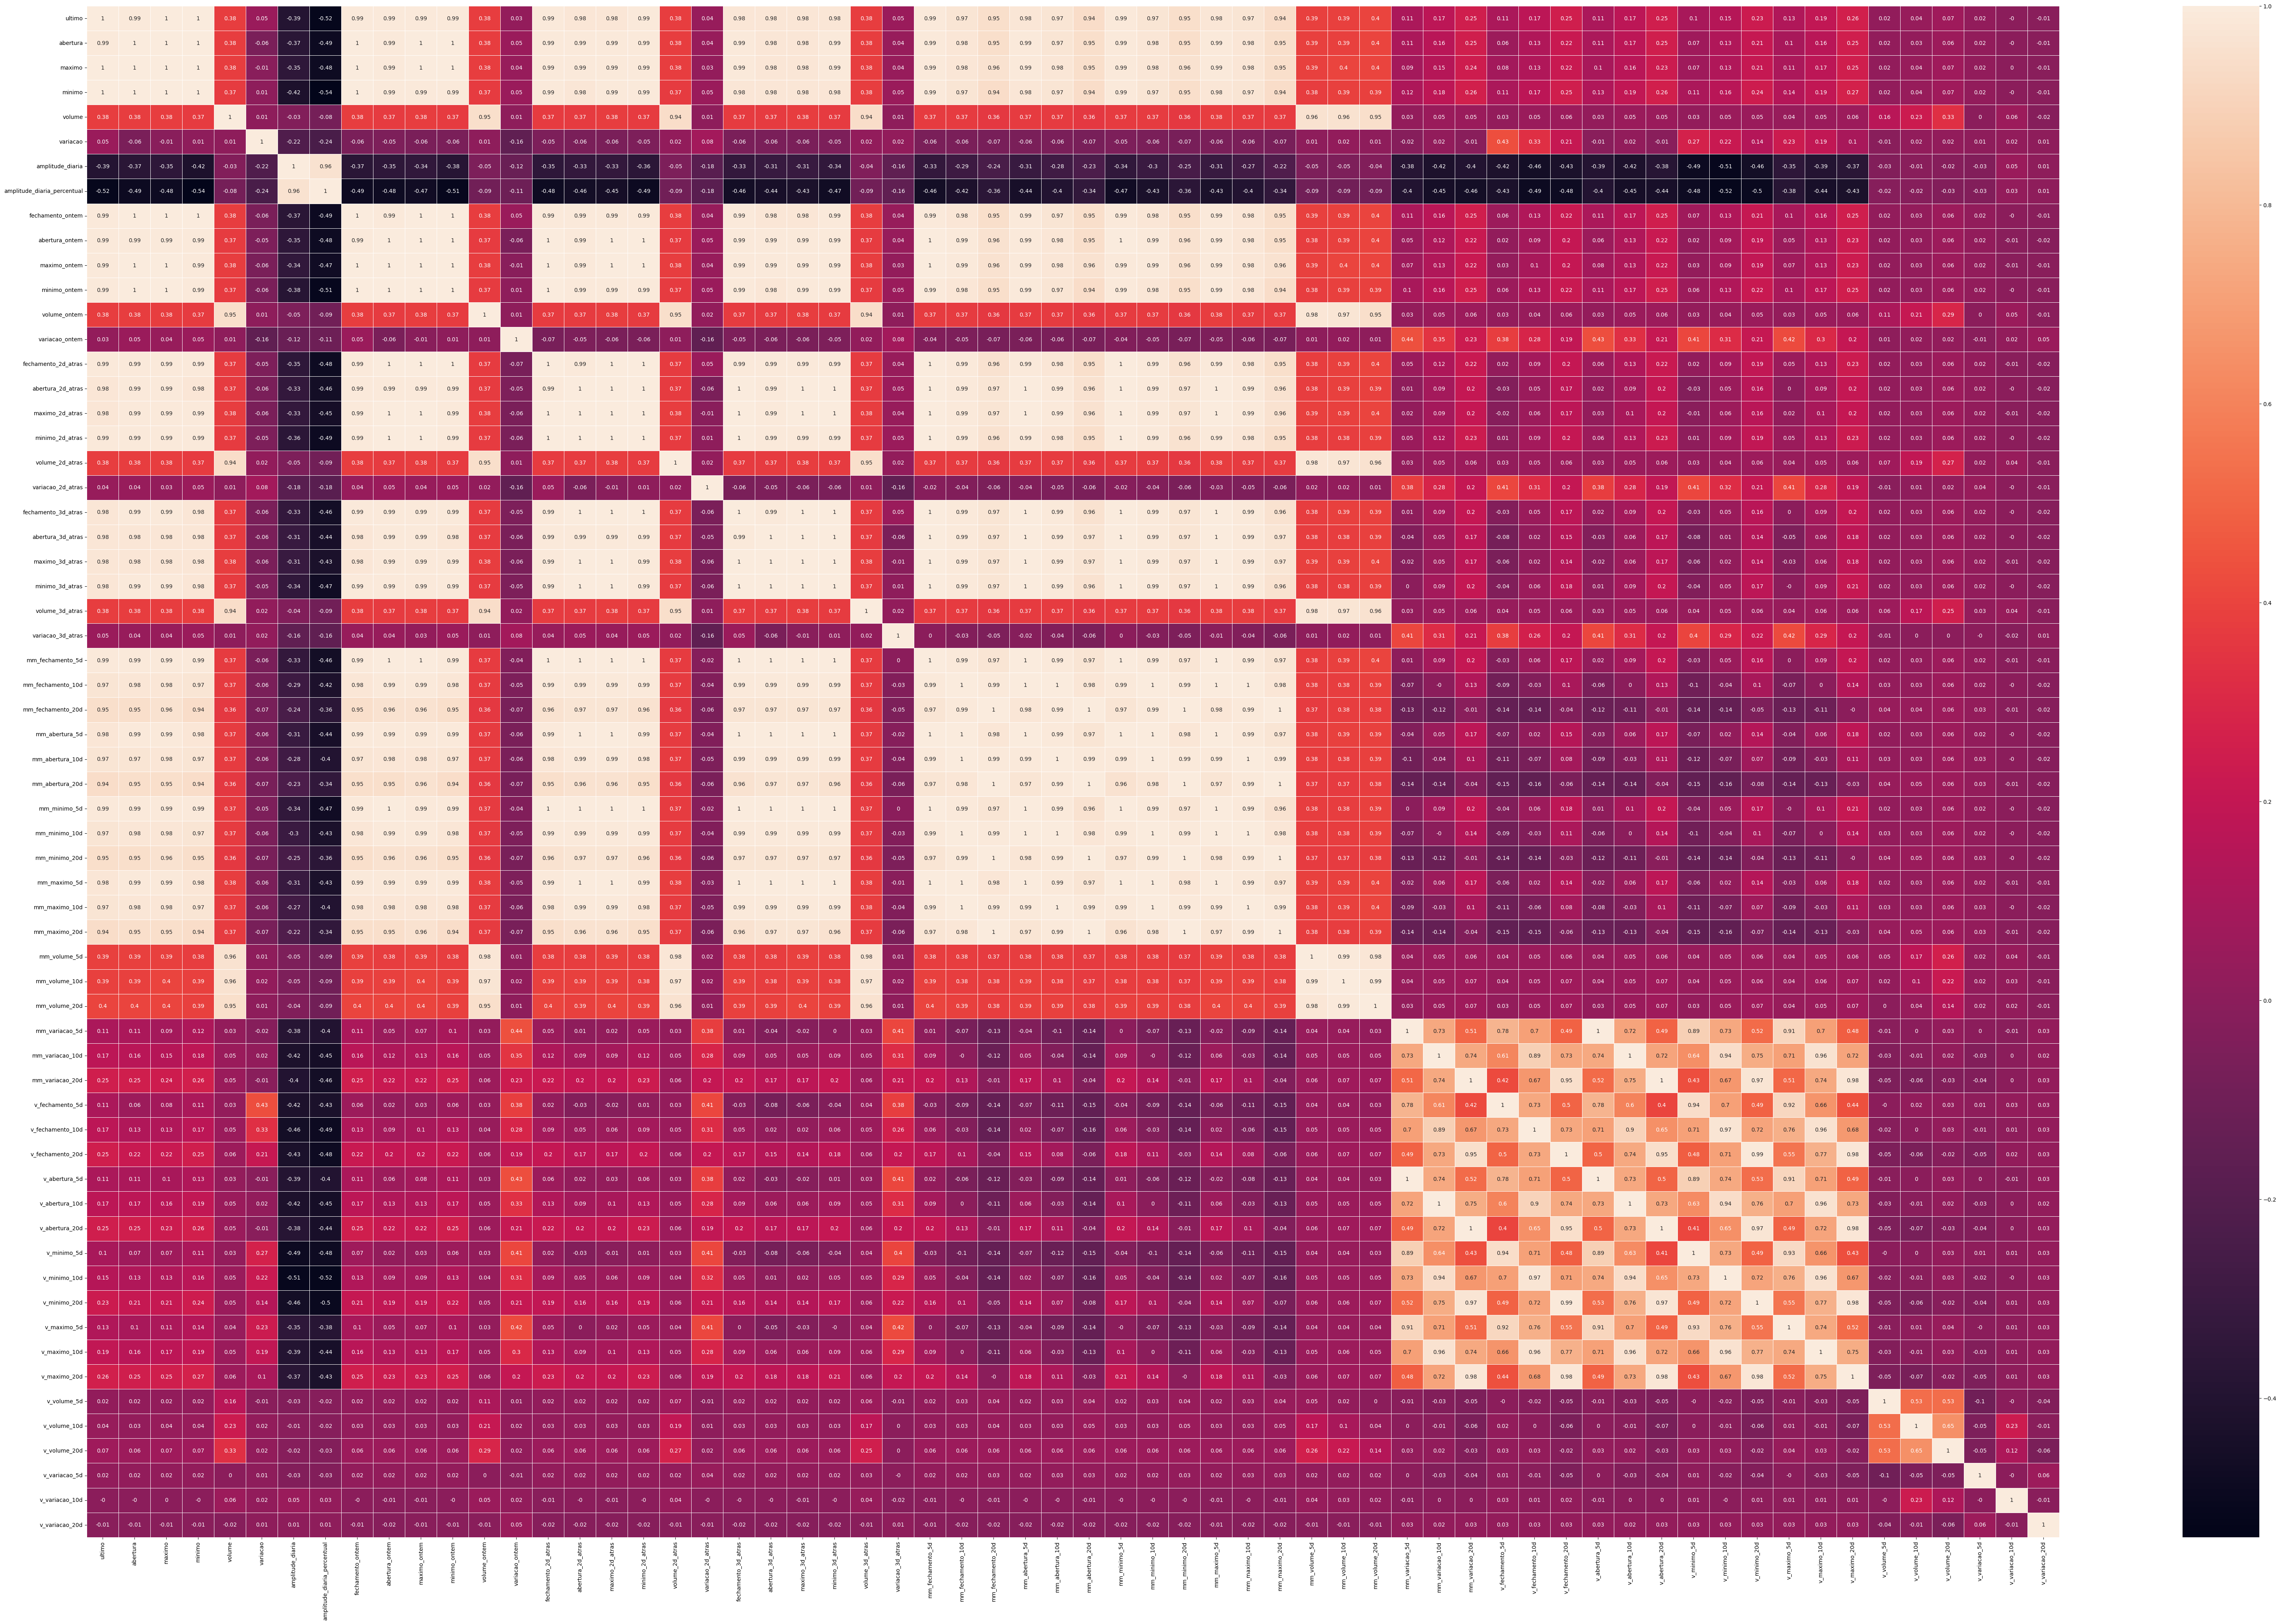

In [126]:
correlation_matrix = df.corr().round(2)

fig, ax = plt.subplots(figsize=(80,50))    
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

## CRIANDO A COLUNA TARGET

In [127]:
#criando a coluna target


df['target_tendencia'] = np.where(
    df['ultimo'].shift(-1).isna(),  # Se não há valor futuro (ultimo dia, que não tem valor no dia seguinte que é futuro)
    np.nan,                         # Retorna NaN
    (df['ultimo'].shift(-1) > df['ultimo']).astype(int)  # Senão, 0 ou 1
)

# Converter para tipo Int que aceita nulos
df['target_tendencia'] = df['target_tendencia'].astype('Int64')



## NOVA TABELA

In [128]:
# --- Correção de valores infinitos e contagem antes da limpeza final ---
print("\n--- Verificando valores infinitos antes da substituição ---")

# Conta os valores infinitos em todo o DataFrame
inf_count = df.isin([np.inf, -np.inf]).sum().sum()
print(f"Total de valores infinitos no DataFrame: {inf_count}")

# Substitui valores infinitos (positivos e negativos) por NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Valores infinitos substituídos por NaN.")

print("\n--- Verificando valores nulos antes da remoção ---")

# Conta o total de valores NaN (incluindo os que eram infinitos) em todo o DataFrame
nan_count_before_dropna = df.isnull().sum().sum()
print(f"Total de valores NaN no DataFrame (incluindo infinitos substituídos): {nan_count_before_dropna}")

# Verifica quantas linhas CONTERÃO pelo menos um NaN (e serão removidas)
initial_rows = df.shape[0]
rows_with_nan = df.isnull().any(axis=1).sum()
print(f"Número de linhas que contêm pelo menos um NaN e serão removidas: {rows_with_nan}")
print(f"Total de linhas no DataFrame antes da remoção: {initial_rows}")


# --- Limpeza final após criação das features ---

# Esta linha agora vai remover todas as linhas com NaN (originais e os que eram infinitos)
df.dropna(inplace=True)
print(f"Total de linhas no DataFrame APÓS remoção de NaNs: {df.shape[0]}")
print(f"Número de linhas perdidas (excluídas): {initial_rows - df.shape[0]}")

print("NaNs (incluindo antigos infinitos) removidos.")


--- Verificando valores infinitos antes da substituição ---
Total de valores infinitos no DataFrame: 9
Valores infinitos substituídos por NaN.

--- Verificando valores nulos antes da remoção ---
Total de valores NaN no DataFrame (incluindo infinitos substituídos): 466
Número de linhas que contêm pelo menos um NaN e serão removidas: 30
Total de linhas no DataFrame antes da remoção: 1494
Total de linhas no DataFrame APÓS remoção de NaNs: 1464
Número de linhas perdidas (excluídas): 30
NaNs (incluindo antigos infinitos) removidos.


In [129]:
df.head()

,ultimo,abertura,maximo,minimo,volume,variacao,amplitude_diaria,amplitude_diaria_percentual,fechamento_ontem,abertura_ontem,...,v_maximo_5d,v_maximo_10d,v_maximo_20d,v_volume_5d,v_volume_10d,v_volume_20d,v_variacao_5d,v_variacao_10d,v_variacao_20d,target_tendencia
data,,,,,,,,,,,,,,,,,,,,,
2019-08-19,99.469,99.810,100.948,98.908,4920000.0,-0.0034,2.040,2.05,99.806,99.059,...,-0.028842,-0.016657,-0.031934,0.090909,-0.046512,0.378151,-0.830000,-0.864542,-1.708333,0
2019-08-20,99.222,99.472,99.665,98.002,5240000.0,-0.0025,1.663,1.68,99.469,99.810,...,-0.039633,-0.024594,-0.045629,0.007692,0.001912,0.253589,-1.183824,-1.121359,0.041667,1
2019-08-21,101.202,99.227,101.240,99.221,5970000.0,0.0200,2.019,2.00,99.222,99.472,...,-0.019657,-0.015022,-0.031845,-0.080123,0.040070,0.189243,-1.680272,2.333333,4.000000,0
2019-08-22,100.011,101.209,101.469,100.011,4500000.0,-0.0118,1.458,1.46,101.202,99.227,...,0.004504,-0.026975,-0.028447,-0.317147,-0.211909,-0.247492,-0.016667,-1.907692,-0.163121,0
2019-08-23,97.667,100.007,100.025,97.085,5670000.0,-0.0234,2.940,3.01,100.011,101.209,...,-0.005389,-0.046000,-0.030850,0.034672,0.208955,0.069811,-4.078947,20.272727,-15.625000,0


In [130]:
df.shape

(1464, 63)

In [131]:
fig = px.line(
    df, 
    x= df.index, 
    y= df['ultimo'],
    title= 'Tendência do IBOVESPA de 2019 a 2025',
    #color='País', #Para definir uma cor a cada coluna de País
    markers=False)  #para incluir marcador deixar = True)

#criando o grafico (figura)

fig.update_layout(
    width= 1000, #ajuste da largura
    height= 500, #ajuste da altura
    #xaxis={'tickangle' : -45}, #ajuste do eixo x {rotação}
    xaxis_title= 'Ano', #titulo eixo x
    yaxis_title= 'Valor', #titulo eixo y
    font_family= 'Arial', #mudando as fontes 
    font_size= 12, #tamanho das fontes
    font_color='grey', #cores da fonte
    title_font_color= 'black', #cores do titulo
    title_font_size= 16 #tamanho do titulo

    )

fig.show()

# CRIANDO MODELOS

## FEATURES

In [132]:
# Selecionando as features

features_selecionadas = [
# 'ultimo',
# 'abertura',
# 'maximo',
# 'minimo',
# 'volume',
# 'variacao',
'amplitude_diaria',
'amplitude_diaria_percentual',
'fechamento_ontem',
'abertura_ontem',
'maximo_ontem',
'minimo_ontem',
'volume_ontem',
'variacao_ontem',
'fechamento_2d_atras',
'abertura_2d_atras',
'maximo_2d_atras',
'minimo_2d_atras',
'volume_2d_atras',
'variacao_2d_atras',
'fechamento_3d_atras',
'abertura_3d_atras',
'maximo_3d_atras',
'minimo_3d_atras',
'volume_3d_atras',
'variacao_3d_atras',
'mm_fechamento_5d',
'mm_fechamento_10d',
'mm_fechamento_20d',
'mm_abertura_5d',
'mm_abertura_10d',
'mm_abertura_20d',
'mm_minimo_5d',
'mm_minimo_10d',
'mm_minimo_20d',
'mm_maximo_5d',
'mm_maximo_10d',
'mm_maximo_20d',
'mm_volume_5d',
'mm_volume_10d',
'mm_volume_20d',
'mm_variacao_5d',
'mm_variacao_10d',
'mm_variacao_20d',
'v_fechamento_5d',
'v_fechamento_10d',
'v_fechamento_20d',
'v_abertura_5d',
'v_abertura_10d',
'v_abertura_20d',
'v_minimo_5d',
'v_minimo_10d',
'v_minimo_20d',
'v_maximo_5d',
'v_maximo_10d',
'v_maximo_20d',
'v_volume_5d',
'v_volume_10d',
'v_volume_20d',
'v_variacao_5d',
'v_variacao_10d',
'v_variacao_20d'
]

## Random Forest Classifier

### 1° TESTE

In [133]:
# --- SEPARAÇÃO DOS DADOS EM FEATURES (X) E TARGET (y) ---

y = df['target_tendencia']

X = df[features_selecionadas]

X.head()

,amplitude_diaria,amplitude_diaria_percentual,fechamento_ontem,abertura_ontem,maximo_ontem,minimo_ontem,volume_ontem,variacao_ontem,fechamento_2d_atras,abertura_2d_atras,...,v_minimo_20d,v_maximo_5d,v_maximo_10d,v_maximo_20d,v_volume_5d,v_volume_10d,v_volume_20d,v_variacao_5d,v_variacao_10d,v_variacao_20d
data,,,,,,,,,,,,,,,,,,,,,
2019-08-19,2.040,2.05,99.806,99.059,100.567,99.059,5480000.0,0.0076,99.057,100.262,...,-0.043924,-0.028842,-0.016657,-0.031934,0.090909,-0.046512,0.378151,-0.830000,-0.864542,-1.708333
2019-08-20,1.663,1.68,99.469,99.810,100.948,98.908,4920000.0,-0.0034,99.806,99.059,...,-0.053285,-0.039633,-0.024594,-0.045629,0.007692,0.001912,0.253589,-1.183824,-1.121359,0.041667
2019-08-21,2.019,2.00,99.222,99.472,99.665,98.002,5240000.0,-0.0025,99.469,99.810,...,-0.043256,-0.019657,-0.015022,-0.031845,-0.080123,0.040070,0.189243,-1.680272,2.333333,4.000000
2019-08-22,1.458,1.46,101.202,99.227,101.240,99.221,5970000.0,0.0200,99.222,99.472,...,-0.023235,0.004504,-0.026975,-0.028447,-0.317147,-0.211909,-0.247492,-0.016667,-1.907692,-0.163121
2019-08-23,2.940,3.01,100.011,101.209,101.469,100.011,4500000.0,-0.0118,101.202,99.227,...,-0.050012,-0.005389,-0.046000,-0.030850,0.034672,0.208955,0.069811,-4.078947,20.272727,-15.625000


In [134]:
# --- DIVISÃO DOS DADOS EM TREINO E TESTE (Últimos 30 dias úteis para teste) ---

num_dias_teste = 30 # Últimos 30 dias úteis para teste
X_train = X.iloc[:-num_dias_teste]
y_train = y.iloc[:-num_dias_teste]

X_test = X.iloc[-num_dias_teste:]
y_test = y.iloc[-num_dias_teste:]

print(f"\n--- Divisão dos Dados ---")
print(f"Tamanho do conjunto de treino (X_train): {X_train.shape}")
print(f"Tamanho do conjunto de teste (X_test): {X_test.shape}")
print(f"Primeira data de treino: {X_train.index.min().strftime('%d/%m/%Y')}")
print(f"Última data de treino: {X_train.index.max().strftime('%d/%m/%Y')}")
print(f"Primeira data de teste: {X_test.index.min().strftime('%d/%m/%Y')}")
print(f"Última data de teste: {X_test.index.max().strftime('%d/%m/%Y')}")



--- Divisão dos Dados ---
Tamanho do conjunto de treino (X_train): (1434, 56)
Tamanho do conjunto de teste (X_test): (30, 56)
Primeira data de treino: 19/08/2019
Última data de treino: 05/06/2025
Primeira data de teste: 06/06/2025
Última data de teste: 18/07/2025


In [135]:
print("\nDistribuição da variável target (treino):")
print(y_train.value_counts(normalize=True))


print("\nDistribuição da variável target (teste):")
print(y_test.value_counts(normalize=True))


Distribuição da variável target (treino):
target_tendencia
1    0.517434
0    0.482566
Name: proportion, dtype: Float64

Distribuição da variável target (teste):
target_tendencia
0    0.566667
1    0.433333
Name: proportion, dtype: Float64


In [136]:
# --- TREINAMENTO DO MODELO RANDOM FOREST ---

# Definindo o modelo e suas características: 
model = RandomForestClassifier(
    random_state=798, 
    n_estimators=30, 
    max_depth=30, 
    min_samples_leaf=3, 
    min_samples_split=52, 
    max_features='sqrt',
    class_weight='balanced') 

# Treinando o modelo com os dados de treino
model.fit(X_train, y_train)

print("Modelo Random Forest treinado com sucesso!")



Modelo Random Forest treinado com sucesso!


In [137]:
# --- PREVISÃO DO MODELO ---

#pedindo para o modelo prever os valores de treino
y_train_pred = model.predict(X_train) 

#pedindo para o modelo prever os valores de teste
y_pred = model.predict(X_test)

print("Previsões realizadas com sucesso!")

Previsões realizadas com sucesso!


In [138]:

print("\n--- ACURÁCIA DO MODELO ---")

#pedindo para o modelo calcular a acurácia do treino
accuracy_train = accuracy_score(y_train, y_train_pred) 

#pedindo para o modelo calcular a acurácia do treino
accuracy = accuracy_score(y_test, y_pred)


print(f"Acurácia no conjunto de treino: {accuracy_train:.2f}") 
print(f"Acurácia no conjunto de teste: {accuracy:.2f}")


--- ACURÁCIA DO MODELO ---
Acurácia no conjunto de treino: 0.85
Acurácia no conjunto de teste: 0.57


In [139]:
accuracy_train = accuracy_train
accuracy_test = accuracy

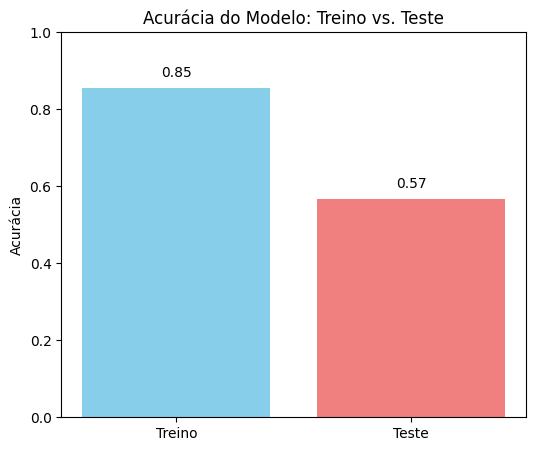

In [140]:
# --- GRAFICO DE ACURACIA DO MODELO ---

# Cria um DataFrame para facilitar a plotagem da acuracia
accuracy_data = pd.DataFrame({
    'Conjunto': ['Treino', 'Teste'],
    'Acuracia': [accuracy_train, accuracy_test]
})

# Cria o gráfico de barras
plt.figure(figsize=(6, 5)) # Define o tamanho da figura
plt.bar(accuracy_data['Conjunto'], accuracy_data['Acuracia'], color=['skyblue', 'lightcoral'])

# # Define o limite do eixo Y de 0 a 1, já que é uma acurácia
plt.ylim(0, 1)

# Adiciona rótulos e título
plt.ylabel('Acurácia')
plt.title('Acurácia do Modelo: Treino vs. Teste')

# # Adiciona uma grade no eixo Y para melhor leitura
# plt.grid(axis='y', linestyle='--')

# Adiciona os valores de acurácia no topo das barras
for index, value in enumerate(accuracy_data['Acuracia']):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')


plt.show()


Relatório de Classificação (modelo treinado):
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72        17
         1.0       0.00      0.00      0.00        13

    accuracy                           0.57        30
   macro avg       0.28      0.50      0.36        30
weighted avg       0.32      0.57      0.41        30



c:\Users\gesia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\gesia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\gesia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\gesia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined

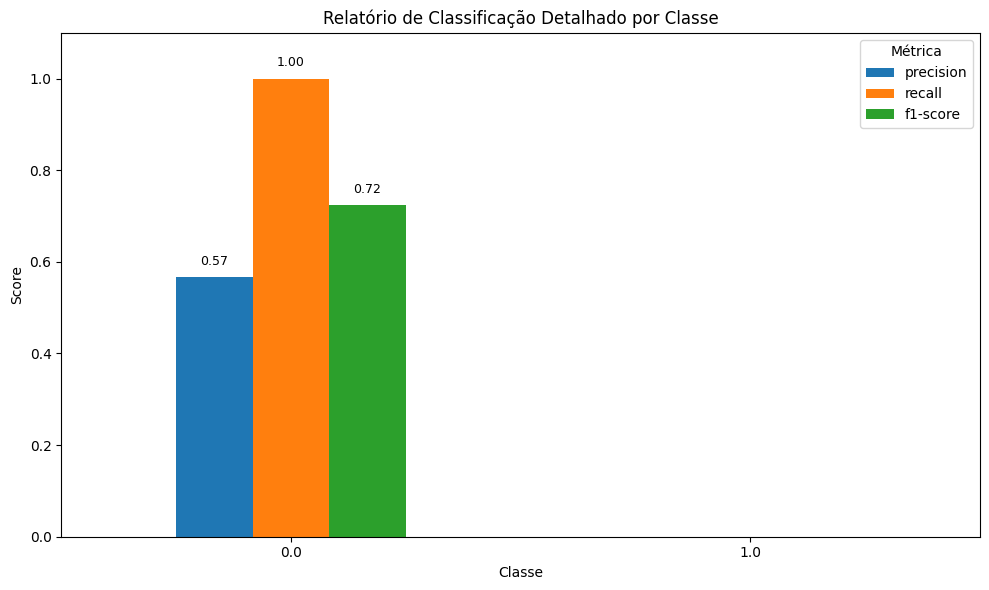


Matriz de Confusão
[[17  0]
 [13  0]]


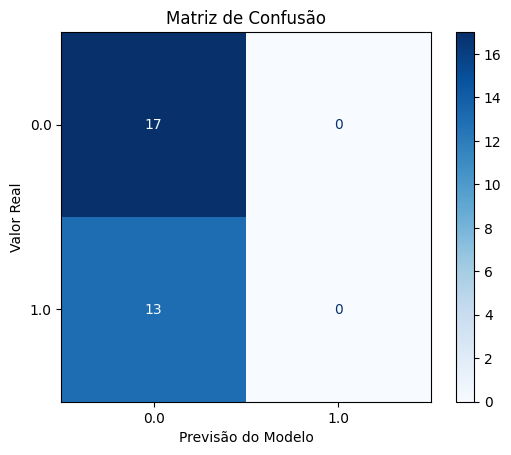

In [141]:
print("\nRelatório de Classificação (modelo treinado):")

# Gerando o relatório de classificação para as previsões no conjunto de teste
print(classification_report(y_test, y_pred))


###################

# Gerar o relatório de classificação como um dicionário
# Usamos 'output_dict=True' para obter os dados de forma estruturada.
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Converter o dicionário para um DataFrame do Pandas
df_report = pd.DataFrame(report_dict).transpose()

# Remover linhas de métricas globais para focar nas classes individuais
# 'accuracy', 'macro avg' e 'weighted avg' são médias e não representam classes específicas.
# 'support' é o número de amostras por classe, que não é plotado diretamente aqui.
df_plot = df_report.drop(columns=['support'], axis=1).drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Assegurar que os nomes das classes (índices) são strings para exibição
df_plot.index = df_plot.index.astype(str)

# Criar o Gráfico de Barras
fig, ax = plt.subplots(figsize=(10, 6))
df_plot[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax)

# Adicionar Títulos, Rótulos e Ajustes Visuais
ax.set_title('Relatório de Classificação Detalhado por Classe')
ax.set_ylabel('Score')
ax.set_xlabel('Classe')
ax.set_ylim(0, 1.1) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # Garante que os rótulos das classes não girem
ax.legend(title='Métrica') # Adiciona uma legenda para as métricas (precisão, recall, f1-score)



# Adicionar o valor numérico no topo de cada coluna (barra)
# 'ax.containers' contém os grupos de barras (um para precisão, um para recall, etc.)
for container in ax.containers:
    # 'bar' representa cada barra individual dentro de um grupo
    for bar in container:
        height = bar.get_height() # Pega a altura da barra (o valor da métrica)
        if height > 0: # Evita adicionar rótulos a barras com valor zero
            ax.text(bar.get_x() + bar.get_width() / 2, # Posição X: centro da barra
                    height + 0.02, # Posição Y: um pouco acima da barra
                    f'{height:.2f}', # Formata o valor para 2 casas decimais
                    ha='center', va='bottom', # Alinhamento horizontal e vertical do texto
                    fontsize=9) # Define o tamanho da fonte do rótulo

#  Ajustar o layout para garantir que nada se sobreponha
plt.tight_layout()

# #  Salvar o Gráfico como um arquivo de imagem
# plt.savefig('relatorio_classificacao_grafico_com_rotulos.png')

plt.show()

########################
# MATRIZ CONFUSÃO
print("\nMatriz de Confusão")
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print(cm)


# Exibindo a matriz de confusão graficamente
# Usamos 'model.classes_' para garantir que os rótulos estão corretos.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Previsão do Modelo')

plt.show()


In [142]:
# Cria um DataFrame para visualizar a importância de cada feature

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importances.head()

,feature,importance
51,v_volume_10d,0.038901
46,v_minimo_20d,0.031864
40,v_fechamento_20d,0.031395
50,v_volume_5d,0.029655
34,mm_volume_20d,0.029125


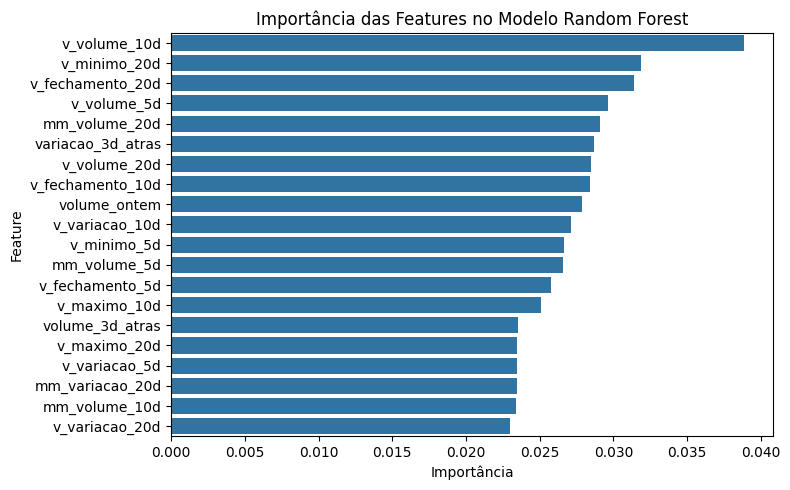

In [143]:
# Plotando a importância das features
plt.figure(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20)) # Top N features
plt.title('Importância das Features no Modelo Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [144]:

#selecionando as 15 features mais importantes
feature_select = feature_importances.head(20)

# feature_select = feature_select['feature'].values

feature_select['feature'].to_list()

['v_volume_10d',
 'v_minimo_20d',
 'v_fechamento_20d',
 'v_volume_5d',
 'mm_volume_20d',
 'variacao_3d_atras',
 'v_volume_20d',
 'v_fechamento_10d',
 'volume_ontem',
 'v_variacao_10d',
 'v_minimo_5d',
 'mm_volume_5d',
 'v_fechamento_5d',
 'v_maximo_10d',
 'volume_3d_atras',
 'v_maximo_20d',
 'v_variacao_5d',
 'mm_variacao_20d',
 'mm_volume_10d',
 'v_variacao_20d']

In [145]:
# TOP 20 TESTE 1

top_20_features = ['v_volume_10d',
 'v_minimo_20d',
 'v_volume_5d',
 'v_fechamento_10d',
 'v_fechamento_20d',
 'mm_volume_20d',
 'v_volume_20d',
 'variacao_3d_atras',
 'v_fechamento_5d',
 'volume_ontem',
 'v_variacao_10d',
 'v_minimo_5d',
 'mm_volume_5d',
 'v_variacao_5d',
 'mm_volume_10d',
 'v_maximo_10d',
 'volume_3d_atras',
 'v_maximo_20d',
 'v_variacao_20d',
 'mm_variacao_10d'
]

In [146]:
# feature_select = feature_select['feature'].to_list()
feature_select = top_20_features

### 2° TESTE - RODANDO MODELO COM AS PRINCIPAIS FEATURES

In [147]:
df[feature_select].head()

,v_volume_10d,v_minimo_20d,v_volume_5d,v_fechamento_10d,v_fechamento_20d,mm_volume_20d,v_volume_20d,variacao_3d_atras,v_fechamento_5d,volume_ontem,v_variacao_10d,v_minimo_5d,mm_volume_5d,v_variacao_5d,mm_volume_10d,v_maximo_10d,volume_3d_atras,v_maximo_20d,v_variacao_20d,mm_variacao_10d
data,,,,,,,,,,,,,,,,,,,,
2019-08-19,-0.046512,-0.043924,0.090909,-0.006284,-0.043098,5218500.0,0.378151,-0.0294,-0.024000,5480000.0,-0.864542,-0.026697,5654000.0,-0.830000,5480000.0,-0.016657,6490000.0,-0.031934,-1.708333,-0.00268
2019-08-20,0.001912,-0.053285,0.007692,-0.028797,-0.043219,5286000.0,0.253589,-0.0120,-0.039468,4920000.0,-1.121359,-0.033644,5736000.0,-1.183824,5456000.0,-0.024594,6590000.0,-0.045629,0.041667,-0.00051
2019-08-21,0.040070,-0.043256,-0.080123,-0.015372,-0.028025,5339000.0,0.189243,0.0076,0.009416,5240000.0,2.333333,-0.007343,5744000.0,-1.680272,5457000.0,-0.015022,5480000.0,-0.031845,4.000000,-0.00282
2019-08-22,-0.211909,-0.023235,-0.317147,-0.039418,-0.025756,5386500.0,-0.247492,-0.0034,0.009631,5970000.0,-1.907692,0.018442,5640000.0,-0.016667,5480000.0,-0.026975,4920000.0,-0.028447,-0.163121,-0.00142
2019-08-23,0.208955,-0.050012,0.034672,-0.060858,-0.050107,5312500.0,0.069811,-0.0025,-0.021432,4500000.0,20.272727,-0.019928,5222000.0,-4.078947,5359000.0,-0.046000,5240000.0,-0.030850,-15.625000,-0.00390


In [148]:
# --- SEPARAÇÃO DOS DADOS EM FEATURES (X) E TARGET (y) ---

y = df['target_tendencia']

X = df[feature_select]

X.head()

,v_volume_10d,v_minimo_20d,v_volume_5d,v_fechamento_10d,v_fechamento_20d,mm_volume_20d,v_volume_20d,variacao_3d_atras,v_fechamento_5d,volume_ontem,v_variacao_10d,v_minimo_5d,mm_volume_5d,v_variacao_5d,mm_volume_10d,v_maximo_10d,volume_3d_atras,v_maximo_20d,v_variacao_20d,mm_variacao_10d
data,,,,,,,,,,,,,,,,,,,,
2019-08-19,-0.046512,-0.043924,0.090909,-0.006284,-0.043098,5218500.0,0.378151,-0.0294,-0.024000,5480000.0,-0.864542,-0.026697,5654000.0,-0.830000,5480000.0,-0.016657,6490000.0,-0.031934,-1.708333,-0.00268
2019-08-20,0.001912,-0.053285,0.007692,-0.028797,-0.043219,5286000.0,0.253589,-0.0120,-0.039468,4920000.0,-1.121359,-0.033644,5736000.0,-1.183824,5456000.0,-0.024594,6590000.0,-0.045629,0.041667,-0.00051
2019-08-21,0.040070,-0.043256,-0.080123,-0.015372,-0.028025,5339000.0,0.189243,0.0076,0.009416,5240000.0,2.333333,-0.007343,5744000.0,-1.680272,5457000.0,-0.015022,5480000.0,-0.031845,4.000000,-0.00282
2019-08-22,-0.211909,-0.023235,-0.317147,-0.039418,-0.025756,5386500.0,-0.247492,-0.0034,0.009631,5970000.0,-1.907692,0.018442,5640000.0,-0.016667,5480000.0,-0.026975,4920000.0,-0.028447,-0.163121,-0.00142
2019-08-23,0.208955,-0.050012,0.034672,-0.060858,-0.050107,5312500.0,0.069811,-0.0025,-0.021432,4500000.0,20.272727,-0.019928,5222000.0,-4.078947,5359000.0,-0.046000,5240000.0,-0.030850,-15.625000,-0.00390


In [149]:
# --- DIVISÃO DOS DADOS EM TREINO E TESTE (Últimos 30 dias úteis para teste) ---

num_dias_teste = 30 # Últimos 30 dias úteis para teste
X_train = X.iloc[:-num_dias_teste]
y_train = y.iloc[:-num_dias_teste]

X_test = X.iloc[-num_dias_teste:]
y_test = y.iloc[-num_dias_teste:]

print(f"\n--- Divisão dos Dados ---")
print(f"Tamanho do conjunto de treino (X_train): {X_train.shape}")
print(f"Tamanho do conjunto de teste (X_test): {X_test.shape}")
print(f"Primeira data de treino: {X_train.index.min().strftime('%d/%m/%Y')}")
print(f"Última data de treino: {X_train.index.max().strftime('%d/%m/%Y')}")
print(f"Primeira data de teste: {X_test.index.min().strftime('%d/%m/%Y')}")
print(f"Última data de teste: {X_test.index.max().strftime('%d/%m/%Y')}")



--- Divisão dos Dados ---
Tamanho do conjunto de treino (X_train): (1434, 20)
Tamanho do conjunto de teste (X_test): (30, 20)
Primeira data de treino: 19/08/2019
Última data de treino: 05/06/2025
Primeira data de teste: 06/06/2025
Última data de teste: 18/07/2025


In [150]:
print("\nDistribuição da variável target (treino):")
print(y_train.value_counts(normalize=True))


print("\nDistribuição da variável target (teste):")
print(y_test.value_counts(normalize=True))


Distribuição da variável target (treino):
target_tendencia
1    0.517434
0    0.482566
Name: proportion, dtype: Float64

Distribuição da variável target (teste):
target_tendencia
0    0.566667
1    0.433333
Name: proportion, dtype: Float64


In [151]:
# --- TREINAMENTO DO MODELO RANDOM FOREST ---

# Definindo o modelo e suas características: 
model = RandomForestClassifier(
    random_state=798, 
    n_estimators=30, 
    max_depth=30, 
    min_samples_leaf=3, 
    min_samples_split=52, 
    max_features='sqrt',
    class_weight='balanced') 

# Treinando o modelo com os dados de treino
model.fit(X_train, y_train)

print("Modelo Random Forest treinado com sucesso!")



Modelo Random Forest treinado com sucesso!


In [152]:
# --- PREVISÃO DO MODELO ---

#pedindo para o modelo prever os valores de treino
y_train_pred = model.predict(X_train) 

#pedindo para o modelo prever os valores de teste
y_pred = model.predict(X_test)

print("Previsões realizadas com sucesso!")

Previsões realizadas com sucesso!


In [153]:

print("\n--- ACURÁCIA DO MODELO ---")

#pedindo para o modelo calcular a acurácia do treino
accuracy_train = accuracy_score(y_train, y_train_pred) 

#pedindo para o modelo calcular a acurácia do treino
accuracy = accuracy_score(y_test, y_pred)


print(f"Acurácia no conjunto de treino: {accuracy_train:.2f}") 
print(f"Acurácia no conjunto de teste: {accuracy:.2f}")


--- ACURÁCIA DO MODELO ---
Acurácia no conjunto de treino: 0.85
Acurácia no conjunto de teste: 0.80


In [154]:
accuracy_train = accuracy_train
accuracy_test = accuracy

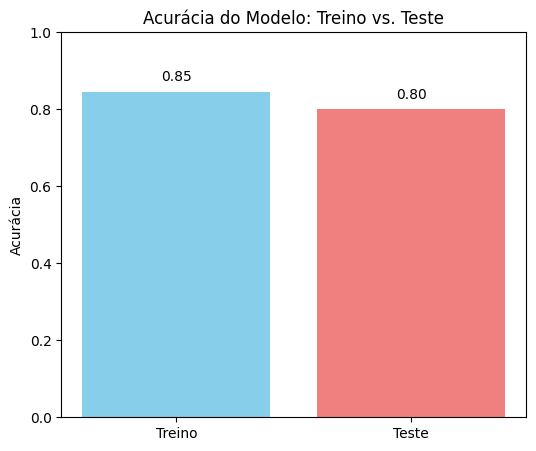

In [155]:
# --- GRAFICO DE ACURACIA DO MODELO ---

# Cria um DataFrame para facilitar a plotagem da acuracia
accuracy_data = pd.DataFrame({
    'Conjunto': ['Treino', 'Teste'],
    'Acuracia': [accuracy_train, accuracy_test]
})

# Cria o gráfico de barras
plt.figure(figsize=(6, 5)) # Define o tamanho da figura
plt.bar(accuracy_data['Conjunto'], accuracy_data['Acuracia'], color=['skyblue', 'lightcoral'])

# # Define o limite do eixo Y de 0 a 1, já que é uma acurácia
plt.ylim(0, 1)

# Adiciona rótulos e título
plt.ylabel('Acurácia')
plt.title('Acurácia do Modelo: Treino vs. Teste')

# # Adiciona uma grade no eixo Y para melhor leitura
# plt.grid(axis='y', linestyle='--')

# Adiciona os valores de acurácia no topo das barras
for index, value in enumerate(accuracy_data['Acuracia']):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')


plt.show()


Relatório de Classificação (modelo treinado):
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        17
         1.0       1.00      0.54      0.70        13

    accuracy                           0.80        30
   macro avg       0.87      0.77      0.77        30
weighted avg       0.85      0.80      0.78        30



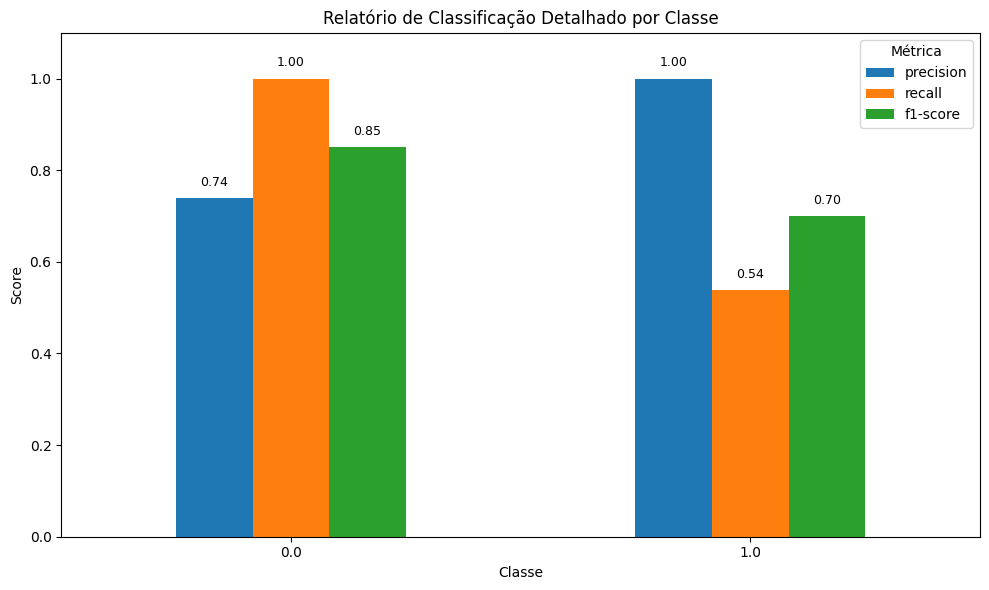


Matriz de Confusão
[[17  0]
 [ 6  7]]


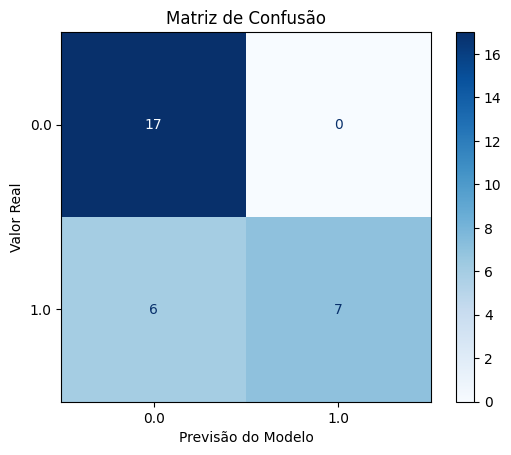

In [156]:
print("\nRelatório de Classificação (modelo treinado):")

# Gerando o relatório de classificação para as previsões no conjunto de teste
print(classification_report(y_test, y_pred))


###################

# Gerar o relatório de classificação como um dicionário
# Usamos 'output_dict=True' para obter os dados de forma estruturada.
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Converter o dicionário para um DataFrame do Pandas
df_report = pd.DataFrame(report_dict).transpose()

# Remover linhas de métricas globais para focar nas classes individuais
# 'accuracy', 'macro avg' e 'weighted avg' são médias e não representam classes específicas.
# 'support' é o número de amostras por classe, que não é plotado diretamente aqui.
df_plot = df_report.drop(columns=['support'], axis=1).drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Assegurar que os nomes das classes (índices) são strings para exibição
df_plot.index = df_plot.index.astype(str)

# Criar o Gráfico de Barras
fig, ax = plt.subplots(figsize=(10, 6))
df_plot[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax)

# Adicionar Títulos, Rótulos e Ajustes Visuais
ax.set_title('Relatório de Classificação Detalhado por Classe')
ax.set_ylabel('Score')
ax.set_xlabel('Classe')
ax.set_ylim(0, 1.1) # Ajusta o limite superior do eixo Y para dar espaço aos rótulos
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # Garante que os rótulos das classes não girem
ax.legend(title='Métrica') # Adiciona uma legenda para as métricas (precisão, recall, f1-score)



# Adicionar o valor numérico no topo de cada coluna (barra)
# 'ax.containers' contém os grupos de barras (um para precisão, um para recall, etc.)
for container in ax.containers:
    # 'bar' representa cada barra individual dentro de um grupo
    for bar in container:
        height = bar.get_height() # Pega a altura da barra (o valor da métrica)
        if height > 0: # Evita adicionar rótulos a barras com valor zero
            ax.text(bar.get_x() + bar.get_width() / 2, # Posição X: centro da barra
                    height + 0.02, # Posição Y: um pouco acima da barra
                    f'{height:.2f}', # Formata o valor para 2 casas decimais
                    ha='center', va='bottom', # Alinhamento horizontal e vertical do texto
                    fontsize=9) # Define o tamanho da fonte do rótulo

#  Ajustar o layout para garantir que nada se sobreponha
plt.tight_layout()

# #  Salvar o Gráfico como um arquivo de imagem
# plt.savefig('relatorio_classificacao_grafico_com_rotulos.png')

plt.show()

########################
# MATRIZ CONFUSÃO
print("\nMatriz de Confusão")
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print(cm)


# Exibindo a matriz de confusão graficamente
# Usamos 'model.classes_' para garantir que os rótulos estão corretos.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Previsão do Modelo')

plt.show()


### 3° TESTE - PARAMETROS

In [157]:
# # --- SEPARAÇÃO DOS DADOS EM FEATURES (X) E TARGET (y) ---

# y = df['target_tendencia']

# X = df[features_selecionadas]

# X.head()

In [158]:
# # --- DIVISÃO DOS DADOS EM TREINO E TESTE ---
# num_dias_teste = 30
# X_train_full = X.iloc[:-num_dias_teste]
# y_train_full = y.iloc[:-num_dias_teste]

# X_test = X.iloc[-num_dias_teste:]
# y_test = y.iloc[-num_dias_teste:]

In [159]:
# print(f"\n--- Iniciando Ajuste de Hiperparâmetros (Grid Search) ---")


In [160]:
# # 1. Definir o range de hiperparâmetros a serem testados
# param_grid = {
#     'n_estimators': [29, 30, 31, 32], # Número de árvores
#     'max_depth': [20, 30, 40, None], # Profundidade máxima da árvore (Adicionei 20 para testar mais fundas se precisar, None = ilimitada)
#     'min_samples_leaf': [1, 2, 3, 4], # Número mínimo de amostras em um nó folha
#     'min_samples_split': [50, 52, 60, 70], # Número mínimo de amostras para dividir um nó
#     'max_features': ['auto', 'sqrt', 'log2'],  # Número de features a serem consideradas para encontrar a melhor divisão
#     'class_weight': ['balanced', None]  # Pesos das classes para lidar com desbalanceamento
# }

# # 2. Inicializar o modelo base
# base_model = RandomForestClassifier(random_state=798, class_weight='balanced')

# # 3. Configurar a validação cruzada para séries temporais
# tscv = TimeSeriesSplit(n_splits=5)

# # 4. Configurar o GridSearchCV
# # ATENÇÃO: Mudança da métrica de scoring para f1_weighted
# grid_search = GridSearchCV(
#     estimator=base_model,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='f1_weighted', # MUDANÇA AQUI: Para focar em um desempenho balanceado entre as classes
#     verbose=2,
#     n_jobs=-1
# )

# # 4. Configurar o GridSearchCV
# # ATENÇÃO: Mudança da métrica de scoring para f1_weighted
# grid_search = GridSearchCV(
#     estimator=base_model,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='f1_weighted', # MUDANÇA AQUI: Para focar em um desempenho balanceado entre as classes
#     verbose=2,
#     n_jobs=-1
# )

# # 5. Executar o Grid Search no conjunto de treino COMPLETO
# grid_search.fit(X_train_full, y_train_full)

# print("\n--- Ajuste de Hiperparâmetros Concluído ---")



In [161]:
# # 6. Exibir os melhores parâmetros encontrados
# print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

In [162]:
# #  7. Exibir a melhor acurácia média da validação cruzada
# # OBS: O score será o f1_weighted, não a acurácia.
# print(f"Melhor score da validação cruzada (f1_weighted): {grid_search.best_score_:.2f}")

In [163]:
# # 8. Obter o melhor modelo treinado (com os melhores parâmetros)
# best_model = grid_search.best_estimator_

# # --- REAVALIAR O MODELO NO CONJUNTO DE TESTE FINAL COM OS MELHORES PARÂMETROS ---
# print("\n--- Reavaliando o Modelo Final no Conjunto de Teste ---")

# y_pred_tuned = best_model.predict(X_test)

# accuracy_train = accuracy_score(y_train, y_train_pred)
# accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
# print(f"Acurácia no conjunto de teste (modelo ajustado): {accuracy_train:.2f}")
# print(f"Acurácia no conjunto de teste (modelo ajustado): {accuracy_tuned:.2f}")

# print("\nRelatório de Classificação (modelo ajustado):")
# print(classification_report(y_test, y_pred_tuned))

# print("\nMatriz de Confusão (modelo ajustado):")
# cm_tuned = confusion_matrix(y_test, y_pred_tuned)
# print(cm_tuned)

# disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=best_model.classes_)
# disp_tuned.plot(cmap=plt.cm.Blues)
# plt.title('Matriz de Confusão (Modelo Ajustado)')
# plt.show()

In [164]:
# # --- Importância das Features do Melhor Modelo ---
# print("\n--- Importância das Features (Melhor Modelo) ---")
# feature_importances_tuned = pd.DataFrame({
#     'feature': X_train_full.columns,
#     'importance': best_model.feature_importances_
# }).sort_values(by='importance', ascending=False)

# print(feature_importances_tuned)

In [165]:
# plt.figure(figsize=(12, 8))
# sns.barplot(x='importance', y='feature', data=feature_importances_tuned.head(15))
# plt.title('Importância das Features no Melhor Modelo Random Forest')
# plt.xlabel('Importância')
# plt.ylabel('Feature')
# plt.tight_layout()
# plt.show()